# **Top Highlights 📌**

---

1. **EDA** performed on the given dataset **matches** the **insights obtained by LIME** on the trained models.

2. **EDA** performed also **matches** the **Partial Dependence Plots (PDPs)**

3. Use of **oversampling** techniques like **SMOTE and ADASYN** to **manage class imbalance.** 


---



# **Assignment Layout 📎**


---

1. **Exploratory Data Analysis (EDA):** First, we perform EDA to extract several basic insights. 

2. **Preparing Data:** Next, we fix the class imbalance problem. 

3. **Model Building & Interpretability:** Finally, we train several tree-based models and use LIME to interpret them. We also explore Partial Dependence Plots (PDPs) to validate our EDA.

4. **Summary and Conclusion:** We present a short summary and conclude with some final words. 

---





In [ ]:
!pip install -U imbalanced-learn

In [ ]:
!pip install lime

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
import lime
plt.style.use('seaborn-darkgrid')

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest,chi2,f_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from lime.lime_tabular import LimeTabularExplainer
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, r2_score
from matplotlib.pyplot import style
from sklearn.utils import resample
from sklearn.inspection import plot_partial_dependence

## **Exploratory Data Analysis 🔧**

---
* In this section we will try to derive some simple, common sense guided insights using EDA. 

* We will then try to see if our insights match the model's learnt rules.

---




### **Load Dataset**

In [ ]:
df = pd.read_excel('/content/default of credit card clients.xls', header=1)

In [ ]:
df.head()

ID  LIMIT_BAL  SEX  ...  PAY_AMT5  PAY_AMT6  default payment next month
0   1      20000    2  ...         0         0                           1
1   2     120000    2  ...         0      2000                           1
2   3      90000    2  ...      1000      5000                           0
3   4      50000    2  ...      1069      1000                           0
4   5      50000    1  ...       689       679                           0

[5 rows x 25 columns]

### **Some Basic Clean Up!**

---

1. We replace `default payment next month` with `TARGET`
2. We can also drop the `ID` column, since it is not going to provide us any useful information and may end up introducing bias.

---





In [ ]:
df = df.rename(columns = {'default payment next month': 'TARGET'})
df = df.drop('ID', axis = 1)
df.head()

LIMIT_BAL  SEX  EDUCATION  MARRIAGE  ...  PAY_AMT4  PAY_AMT5  PAY_AMT6  TARGET
0      20000    2          2         1  ...         0         0         0       1
1     120000    2          2         2  ...      1000         0      2000       1
2      90000    2          2         2  ...      1000      1000      5000       0
3      50000    2          2         1  ...      1100      1069      1000       0
4      50000    1          2         1  ...      9000       689       679       0

[5 rows x 24 columns]

### **Unique Values**

---
According to the description at source, there are 9 columns that take on distinct values, i.e, they are label encoded. 

1. **SEX:** `(Male: 1, Female: 2)` 
2. **EDUCATION:** `(Graduate School: 1, University: 2, High School: 3, Others: 4)`
3. **MARRIAGE:** (`Married: 1, Single: 2, Others: 3`)
4. **PAY_0 - PAY_6:** `(Pay Duly: -1, Payment Delay for 1 Month: 1, Payment Delay for 2 Months: 2, . . . Payment Delay for 8 Months: 8 ...)`
5. **default payment next month**: `(Default: 1, No Default: 0)`

We must verify the integrity of these label encodings for each category, and find outliers if they exist.

---




In [ ]:
label_encoded_columns = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'TARGET']

for column in df.columns:
  if column in label_encoded_columns:
    print(column + ': {}'.format(sorted(df[column].unique())))

SEX: [1, 2]
EDUCATION: [0, 1, 2, 3, 4, 5, 6]
MARRIAGE: [0, 1, 2, 3]
PAY_0: [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]
PAY_2: [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]
PAY_3: [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]
PAY_4: [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]
PAY_5: [-2, -1, 0, 2, 3, 4, 5, 6, 7, 8]
PAY_6: [-2, -1, 0, 2, 3, 4, 5, 6, 7, 8]
TARGET: [0, 1]


#### **Observations**



---


1. Values '0', '5', '6' for **`EDUCATION`** are undocumented in the source, so it would be safe to replace these values by '4' (`Others`)

2. Value '0' for **`MARRIAGE`** is undocumented in the source, so it would be safe to repalce these values by '3' (`Others`)

3. **`PAY_0` - `PAY_6`** also have an undocumented values of 0 and -2, we can assume those to be -1 (no default).


---



In [ ]:
pay_columns = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
df.loc[(df.EDUCATION == 0) | (df.EDUCATION == 5) | (df.EDUCATION == 6), 'EDUCATION'] = 4
df.loc[df.MARRIAGE == 0, 'MARRIAGE'] = 3
df.loc[(df.PAY_0 == -2) | (df.PAY_0 == -1) | (df.PAY_0 == 0), 'PAY_0'] = 0
df.loc[(df.PAY_2 == -2) | (df.PAY_2 == -1) | (df.PAY_2 == 0), 'PAY_2'] = 0
df.loc[(df.PAY_3 == -2) | (df.PAY_3 == -1) | (df.PAY_3 == 0), 'PAY_3'] = 0
df.loc[(df.PAY_4 == -2) | (df.PAY_4 == -1) | (df.PAY_4 == 0), 'PAY_4'] = 0
df.loc[(df.PAY_5 == -2) | (df.PAY_5 == -1) | (df.PAY_5 == 0), 'PAY_5'] = 0
df.loc[(df.PAY_6 == -2) | (df.PAY_6 == -1) | (df.PAY_6 == 0), 'PAY_6'] = 0

for column in pay_columns:
  if column in label_encoded_columns:
    print(column + ': {}'.format(sorted(df[column].unique())))

PAY_0: [0, 1, 2, 3, 4, 5, 6, 7, 8]
PAY_2: [0, 1, 2, 3, 4, 5, 6, 7, 8]
PAY_3: [0, 1, 2, 3, 4, 5, 6, 7, 8]
PAY_4: [0, 1, 2, 3, 4, 5, 6, 7, 8]
PAY_5: [0, 2, 3, 4, 5, 6, 7, 8]
PAY_6: [0, 2, 3, 4, 5, 6, 7, 8]


### **Bucketize Age into Age Groups!**

---
* It would be a good idea to bucketize `AGE` into `AGE GROUPS`. 

* This simplifies the data but comes at the cost of losing some information because we are discretising values. 

* But we make peace with this tradeoff because it means we will reduce overfitting to a great degree (the model may learn to overfit based on the exact age of a person).

---





In [ ]:
df['AGE_GROUP'] = pd.cut(df.AGE, [18, 35, 60, 100], labels=[0, 1, 2])
df['AGE_GROUP'].unique()

[0, 1, 2]
Categories (3, int64): [0 < 1 < 2]

### **Class Distribution**

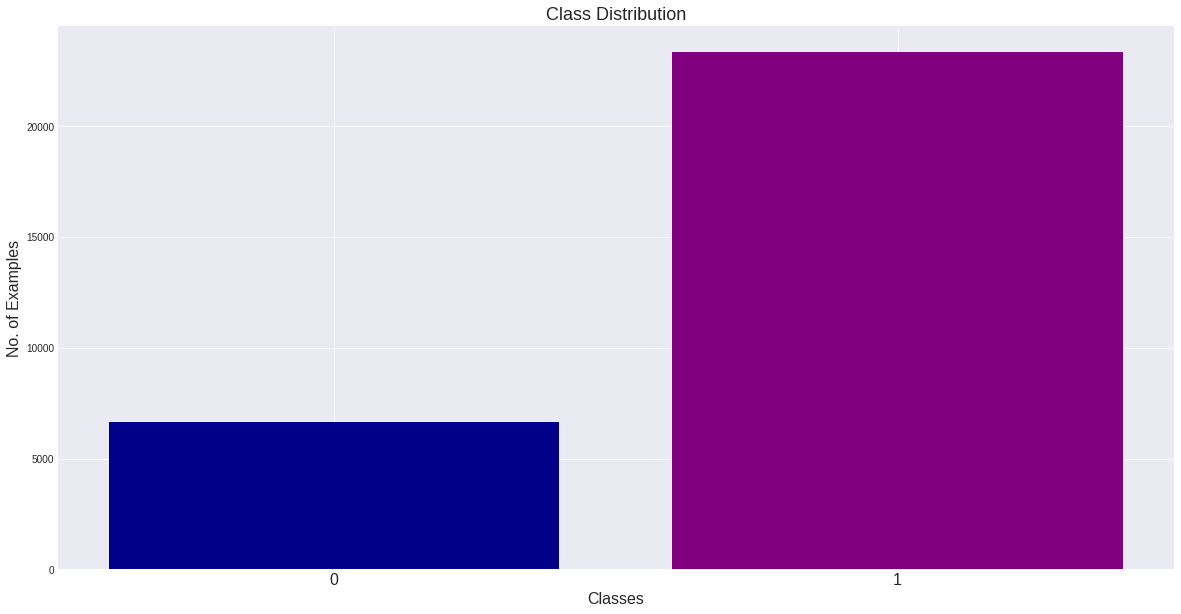

In [ ]:
# plot the class distribution
plt.figure(figsize=(20, 10))
plt.bar(df['TARGET'].unique(), df['TARGET'].value_counts(), color = ['purple','darkblue'])
plt.xticks(df['TARGET'].unique(), fontsize=16)
plt.xlabel('Classes', fontsize=16)
plt.ylabel('No. of Examples', fontsize=16)
plt.title('Class Distribution', fontdict={'fontsize': 18})
plt.show()

#### **Observations**

---

We note that there is severe imbalance in the data. 

However, we will complete our EDA on authentic data and then oversample using ADASYN.

---




### **How is Default Rate impacted by the interplay between social factors such as Sex, Education, Marriage and Age?**

#### **Gender v. Default Rate**

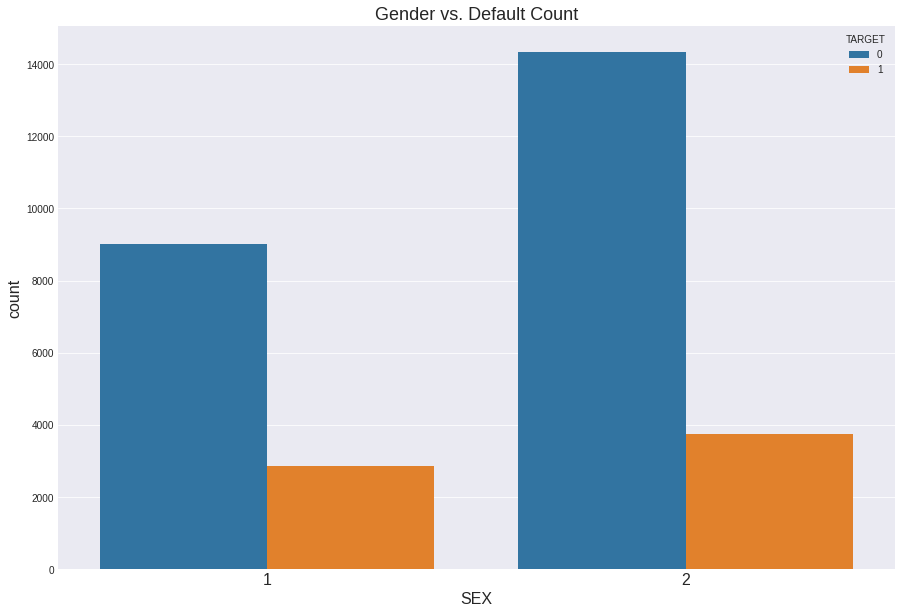

Default % for MALE (1): 24.17
Default % for FEMALE (2): 20.78


In [ ]:
plt.figure(figsize=(15, 10))

plt.xticks(df['SEX'].unique(), fontsize=16)
plt.xlabel('SEX', fontsize=16)
plt.ylabel('', fontsize=16)
plt.title('Gender vs. Default Count', fontdict={'fontsize': 18})
sns.countplot(x='SEX', data=df, hue='TARGET')
plt.show()

sex_vs_tar = pd.crosstab(df['SEX'], df['TARGET'])
default_perc = (sex_vs_tar[1] / (sex_vs_tar[1] + sex_vs_tar[0]) * 100).tolist()
print('Default % for MALE (1): {:.2f}'.format(default_perc[0]))
print('Default % for FEMALE (2): {:.2f}'.format(default_perc[1]))

##### **INSIGHTS**

---

* It seems like statistically, men default more often than women. 

* The reason for this cannot be determined without additional data. This might introduce gender bias, hence some more investigation is neccessary. 


---




#### **Education v. Default Rate**

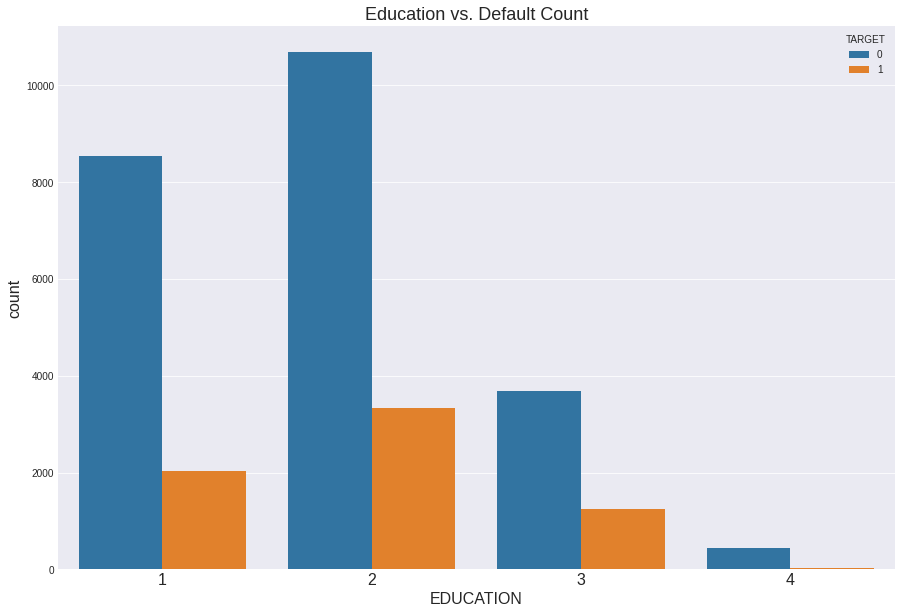

Default % for GRADUATE (1): 19.23
Default % for UNIVERSITY (2): 23.73
Default % for HIGH SCHOOL (3): 25.16
Default % for OTHERS (4): 7.05


In [ ]:
plt.figure(figsize=(15, 10))

plt.xticks(df['EDUCATION'].unique(), fontsize=16)
plt.xlabel('EDUCATION', fontsize=16)
plt.ylabel('', fontsize=16)
plt.title('Education vs. Default Count', fontdict={'fontsize': 18})
sns.countplot(x='EDUCATION', data=df, hue='TARGET')
plt.show()

edu_vs_tar = pd.crosstab(df['EDUCATION'], df['TARGET'])
default_perc = (edu_vs_tar[1] / (edu_vs_tar[1] + edu_vs_tar[0]) * 100).tolist()

print('Default % for GRADUATE (1): {:.2f}'.format(default_perc[0]))
print('Default % for UNIVERSITY (2): {:.2f}'.format(default_perc[1]))
print('Default % for HIGH SCHOOL (3): {:.2f}'.format(default_perc[2]))
print('Default % for OTHERS (4): {:.2f}'.format(default_perc[3]))

##### INSIGHTS

---

* The default rate increases in decreasing order of the level of education attained. 

* Specifically, the lower default rate is for a `GRADUATE` and the highest default rate is for `HIGH SCHOOL`. 

* The `OTHERS` category has the lowest default rate, but is undocumented and there exists very less data points for it anyway, so we will exclude it from our discussion until further data is available. 

---



#### **Marriage v. Default Rate**

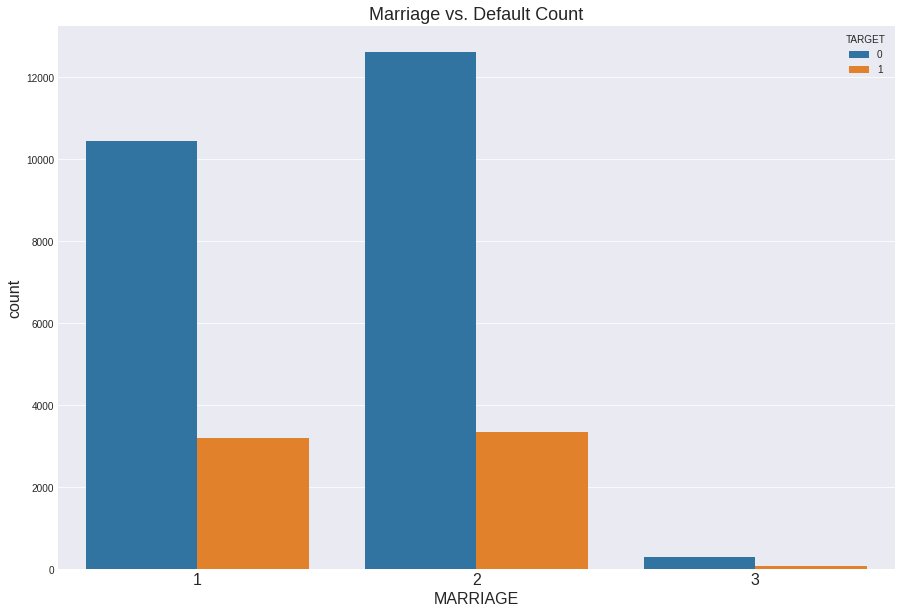

Default % for MARRIED (1): 23.47
Default % for SINGLE (2): 20.93
Default % for OTHERS (3): 23.61


In [ ]:
plt.figure(figsize=(15, 10))

plt.xticks(df['MARRIAGE'].unique(), fontsize=16)
plt.xlabel('MARRIAGE', fontsize=16)
plt.ylabel('', fontsize=16)
plt.title('Marriage vs. Default Count', fontdict={'fontsize': 18})
sns.countplot(x='MARRIAGE', data=df, hue='TARGET')
plt.show()

edu_vs_tar = pd.crosstab(df['MARRIAGE'], df['TARGET'])
default_perc = (edu_vs_tar[1] / (edu_vs_tar[1] + edu_vs_tar[0]) * 100).tolist()

print('Default % for MARRIED (1): {:.2f}'.format(default_perc[0]))
print('Default % for SINGLE (2): {:.2f}'.format(default_perc[1]))
print('Default % for OTHERS (3): {:.2f}'.format(default_perc[2]))

##### **INSIGHTS**

---

* Married people tend to have higher default rates than unmarried people.

* The reasons for this could be home loans, car loans, education loans for their kids etc. 

* If the `OTHERS` category here is divorce (the only other option possible), it seems like that has the highest default rate of all. However, very little data exists so we will exclude it from our discussions. 

---



#### **(Gender x Martial Status) v. Default Rate**

In [ ]:
df_copy = df.copy()
df_copy['SEX_X_MARRIAGE'] = 0
df_copy.loc[((df_copy.SEX == 1) & (df_copy.MARRIAGE == 1)) , 'SEX_X_MARRIAGE'] = 1 # married man
df_copy.loc[((df_copy.SEX == 1) & (df_copy.MARRIAGE == 2)) , 'SEX_X_MARRIAGE'] = 2 # single man
df_copy.loc[((df.SEX == 1) & (df_copy.MARRIAGE == 3)) , 'SEX_X_MARRIAGE'] = 3 # other man
df_copy.loc[((df.SEX == 2) & (df_copy.MARRIAGE == 1)) , 'SEX_X_MARRIAGE'] = 4 # married woman
df_copy.loc[((df.SEX == 2) & (df_copy.MARRIAGE == 2)) , 'SEX_X_MARRIAGE'] = 5 # single woman
df_copy.loc[((df.SEX == 2) & (df_copy.MARRIAGE == 3)) , 'SEX_X_MARRIAGE'] = 6 # other woman


sex_x_marriage = pd.crosstab(df_copy['SEX_X_MARRIAGE'], df_copy['TARGET'])
default_perc = (sex_x_marriage[1] / (sex_x_marriage[1] + sex_x_marriage[0]) * 100).tolist()

print('Default % for MARRIED MAN: {:.2f}'.format(default_perc[0]))
print('Default % for SINGLE MAN: {:.2f}'.format(default_perc[1]))
print('Default % for OTHER MAN : {:.2f}'.format(default_perc[2]))
print('-' * 40)
print('Default % for MARRIED WOMAN: {:.2f}'.format(default_perc[3]))
print('Default % for SINGLE WOMAN: {:.2f}'.format(default_perc[4]))
print('Default % for OTHER WOMAN: {:.2f}'.format(default_perc[5]))

Default % for MARRIED MAN: 25.93
Default % for SINGLE MAN: 22.66
Default % for OTHER MAN : 28.97
----------------------------------------
Default % for MARRIED WOMAN: 21.96
Default % for SINGLE WOMAN: 19.72
Default % for OTHER WOMAN: 20.26


##### **INSIGHTS**

---

* Married men and divorced men have the highest default rates out of all other categories. 

* Single women have the lowest default rate. 

* Although the increase in the default rate (after marriage) for both the genders is almost equal. 

---






#### **Age Group v. Default Rate**

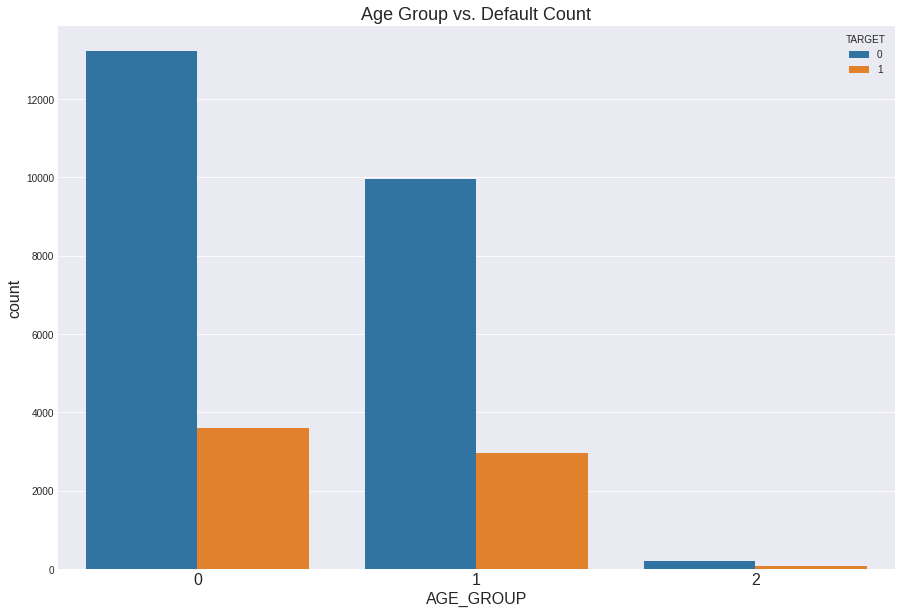

Default % for YOUNG (0): 21.40
Default % for MIDDLE (2): 22.96
Default % for SENIOR (3): 26.84


In [ ]:
plt.figure(figsize=(15, 10))

plt.xticks(df['AGE_GROUP'].unique(), fontsize=16)
plt.xlabel('AGE_GROUP', fontsize=16)
plt.ylabel('', fontsize=16)
plt.title('Age Group vs. Default Count', fontdict={'fontsize': 18})
sns.countplot(x='AGE_GROUP', data=df, hue='TARGET')
plt.show()

agegroup_vs_tar = pd.crosstab(df['AGE_GROUP'], df['TARGET'])
default_perc = (agegroup_vs_tar[1] / (agegroup_vs_tar[1] + agegroup_vs_tar[0]) * 100).tolist()

print('Default % for YOUNG (0): {:.2f}'.format(default_perc[0]))
print('Default % for MIDDLE (2): {:.2f}'.format(default_perc[1]))
print('Default % for SENIOR (3): {:.2f}'.format(default_perc[2]))

##### **INSIGHTS**

---

* It seems like default rate increases with age, especially from `YOUNG` to `MIDDLE`. Although this increase is not significant (~1%) so no real conclusion can be drawn on the age alone. 

* Too little data exists for `SENIOR`, to be confident about this category. 

---





### **How is Default Rate impacted by domain specific factors such as Spending, Repayment Capacity, Credit Limit and Delays in Payment?**

#### **Amount Paid (Current Month) v. Bill (Current Month)**

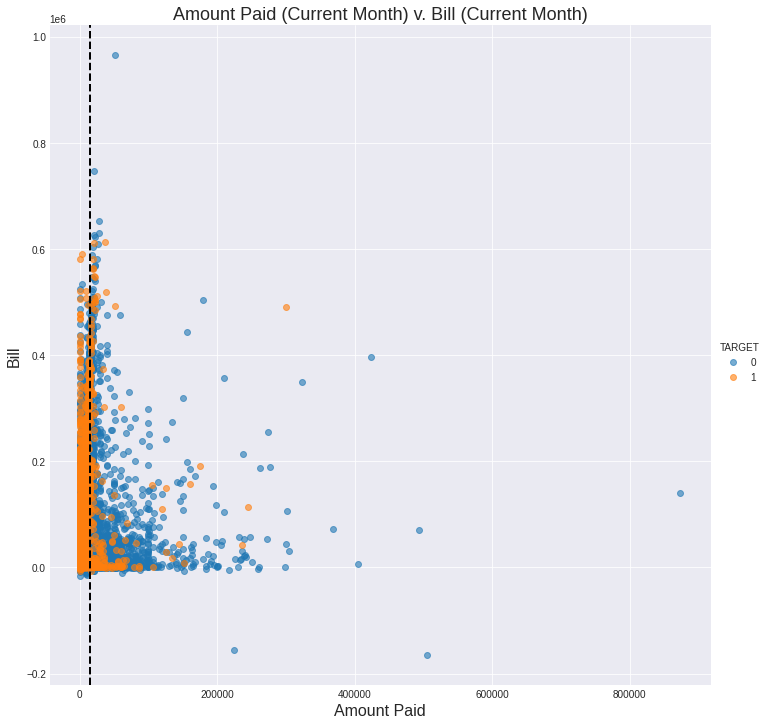

In [ ]:
sns.lmplot(x='PAY_AMT1', y='BILL_AMT1', data=df, hue='TARGET', height = 10, fit_reg=False, scatter_kws={'alpha':0.6})

# Annotation
plt.axvline(x=15000, linewidth=2, color="k", linestyle='--')
plt.xlabel('Amount Paid', fontsize=16)
plt.ylabel('Bill', fontsize=16)
plt.title('Amount Paid (Current Month) v. Bill (Current Month)', fontdict={'fontsize': 18})
plt.show()

##### **INSIGHTS**

---

* The major bulk of defaulters lie in the region where `Amount Paid` (in the current month) is less, and the `Bill` (for current month) is high, which is no surprise. 

* Although the plot shows `PAY_AMT1` (Amount Paid in September) v. `BILL_AM1` (Bill Amount in September), this trend is uniform across all months. 

---




#### **Credit Limit v. Default Rate**

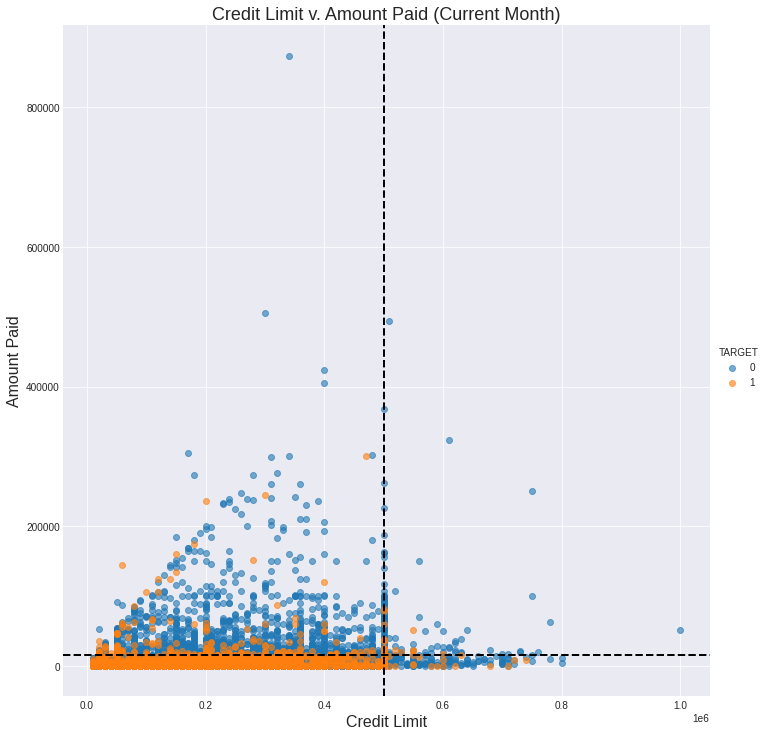

In [ ]:
sns.lmplot(x='LIMIT_BAL', y='PAY_AMT1', data=df, hue='TARGET', height = 10, fit_reg=False, scatter_kws={'alpha':0.6})

# Annotation
plt.xlabel('Credit Limit', fontsize=16)
plt.ylabel('Amount Paid', fontsize=16)
plt.title('Credit Limit v. Amount Paid (Current Month)', fontdict={'fontsize': 18})
plt.axhline(y=15000, linewidth=2, color="k", linestyle='--')
plt.axvline(x=500000, linewidth=2, color="k", linestyle='--')
plt.show()

##### **INSIGHTS**

---

* The major bulk of defaulters lie in the bottom left region where `Amount Paid` is low and `Credit Limit` is below `500,000`. 

* Since `Credit Limits` are assigned based on income, this region represents people who have low or moderate income but are not able to keep up the monthly payments. 

* It would be a good idea for the bank to look at additional factors while assinging `Credit Limits` such as stability of income and existing loans. Although some more data is needed to substantiate this claim. 

---




#### **Delay in Payment v. Default Rate**

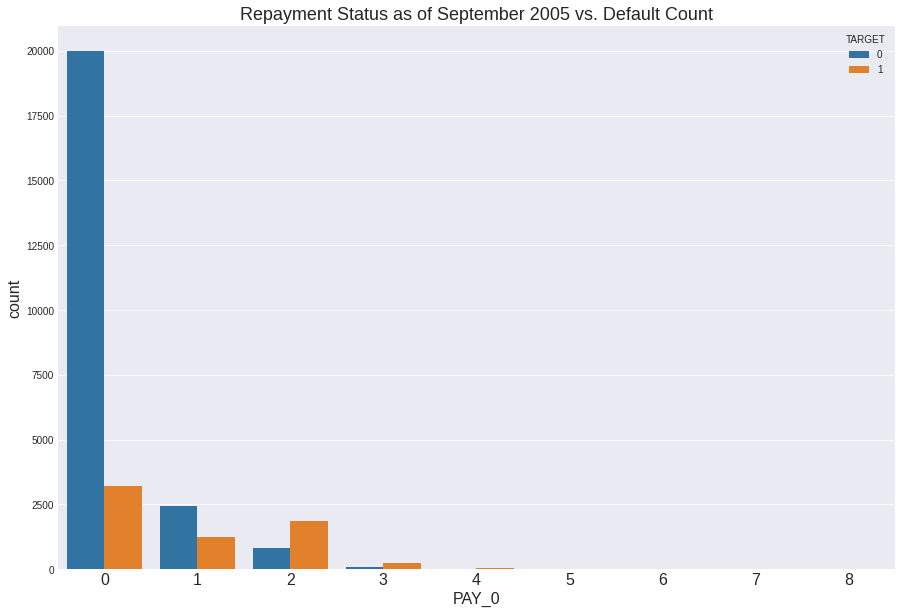

Default % for No Delay (0): 13.83
Default % for 1 Month Delay (1): 33.95
Default % for 2 Month Delay (2): 69.14
Default % for 3 Month Delay (3): 75.78
Default % for 4 Month Delay (4): 68.42
Default % for 5 Month Delay (5): 50.00
Default % for 6 Month Delay (6): 54.55
Default % for 5 Month Delay (7): 77.78
Default % for 6 Month Delay (8): 57.89


In [ ]:
plt.figure(figsize=(15, 10))

plt.xticks(df['PAY_0'].unique(), fontsize=16)
plt.xlabel('PAY_0', fontsize=16)
plt.ylabel('', fontsize=16)
plt.title('Repayment Status as of September 2005 vs. Default Count', fontdict={'fontsize': 18})
sns.countplot(x='PAY_0', data=df, hue='TARGET')
plt.show()

delay_vs_tar = pd.crosstab(df['PAY_0'], df['TARGET'])
default_perc = (delay_vs_tar[1] / (delay_vs_tar[1] + delay_vs_tar[0]) * 100).tolist()


print('Default % for No Delay (0): {:.2f}'.format(default_perc[0]))
print('Default % for 1 Month Delay (1): {:.2f}'.format(default_perc[1]))
print('Default % for 2 Month Delay (2): {:.2f}'.format(default_perc[2]))
print('Default % for 3 Month Delay (3): {:.2f}'.format(default_perc[3]))
print('Default % for 4 Month Delay (4): {:.2f}'.format(default_perc[4]))
print('Default % for 5 Month Delay (5): {:.2f}'.format(default_perc[5]))
print('Default % for 6 Month Delay (6): {:.2f}'.format(default_perc[6]))
print('Default % for 5 Month Delay (7): {:.2f}'.format(default_perc[7]))
print('Default % for 6 Month Delay (8): {:.2f}'.format(default_perc[8]))

##### **INSIGHTS**


---

* Perhaps one of the more important factors is the number of outstanding delays in payment as of the current month. 

* If the number of outstanding delays are less, the default rate is low. 

* If the number of outstanding delays in payment is more, people are more likely to default. 

* Number of datapoints for number of outstanding delays greater than 4 is very less, hence resulting in some inconsistent values for default rates and weakening the trend. 

---





#### **Repayment Capacity v. Spending**

In [ ]:
df_copy = df.copy()

df_copy['total_bill'] = df['BILL_AMT1'] + df['BILL_AMT2'] + df['BILL_AMT3'] + df['BILL_AMT4'] + df['BILL_AMT5'] + df['BILL_AMT6']
df_copy['total_amount_paid'] = df['PAY_AMT1'] + df['PAY_AMT2'] + df['PAY_AMT3'] + df['PAY_AMT4'] + df['PAY_AMT5'] + df['PAY_AMT6']
df_copy['avg_payment_per_month'] = df_copy['total_amount_paid'] / 6
df_copy['avg_bill_per_month'] = df_copy['total_bill'] / 6
df_copy['difference'] = df_copy['avg_bill_per_month'] -  df_copy['avg_payment_per_month']

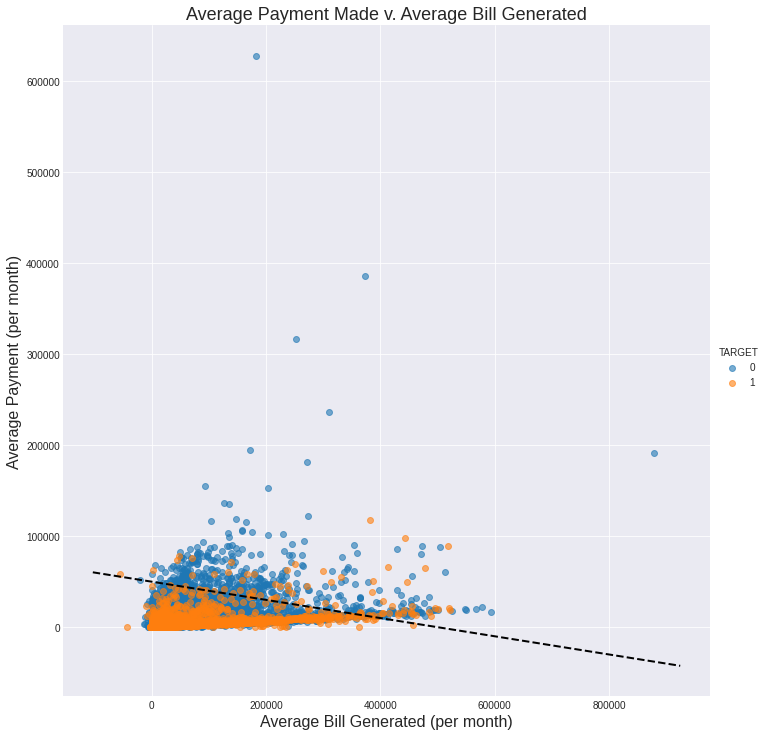

In [ ]:
sns.lmplot(x='avg_bill_per_month', y='avg_payment_per_month', data=df_copy, hue='TARGET', height = 10, fit_reg=False, scatter_kws={'alpha':0.6})


# Annotation
plt.xlabel('Average Bill Generated (per month)', fontsize=16)
plt.ylabel('Average Payment (per month)', fontsize=16)
plt.title('Average Payment Made v. Average Bill Generated', fontdict={'fontsize': 18})

axes = plt.gca()
x_vals = np.array(axes.get_xlim())
y_vals = 50000 + (-0.10) * x_vals
plt.plot(x_vals, y_vals, '--', linewidth=2, color='k')
plt.show()

##### **INSIGHTS**


---

* People who pay less than a threshold amount per month **irrespective** of the amount they spend in the current month make the bulk of defaulters. 


---





## **Oversampling (ADASYN / SMOTE) ➕**


---

Now that we have some insights regarding the data, let us address the class imbalance problem.

---

*Note: We prefer `ADASYN` over `SMOTE` since `ADASYN` is an improvement over `SMOTE` because it adds randomness to the sampling process, which in turn, guards the models against overfitting, making it more robust. This was also experimentally verfied by the author.*


In [ ]:
from imblearn.over_sampling import ADASYN

In [ ]:
ada = ADASYN(random_state=42)

In [ ]:
df_copy = df.copy()

def to_categorical(df, column):
    data_frame = pd.concat([df, pd.get_dummies(df[column], prefix = column + '_')], axis = 1).drop(column, axis = 1)  
    return data_frame

# we can drop "AGE"
df_new = df_copy.drop('AGE', axis = 1)

# convert label encoded values to categorical ones
df_new = to_categorical(df_new,'SEX')
df_new = to_categorical(df_new,'MARRIAGE')
df_new = to_categorical(df_new,'EDUCATION')
df_new = to_categorical(df_new, 'AGE_GROUP')

# rename columns
df_new.rename(columns = {'PAY_0': 'Delays as of September',
                         'PAY_2': 'Delays as of August',
                         'PAY_3': 'Delays as of July',
                         'PAY_4': 'Delays as of June',
                         'PAY_5': 'Delays as of May',
                         'PAY_6': 'Delays as of April',
                         'SEX__1': 'Male',
                         'SEX__2': 'Female',
                         'MARRIAGE__1': 'Married',
                         'MARRIAGE__2': 'Single',
                         'MARRIAGE__3': 'Marriage_Others',
                         'EDUCATION__1': 'Graduate',
                         'EDUCATION__2': 'University',
                         'EDUCATION__3': 'High School',
                         'EDUCATION__4': 'Education_Others',
                         'AGE_GROUP__0': 'Young',
                         'AGE_GROUP__1': 'Middle',
                         'AGE_GROUP__2': 'Senior'}, inplace=True)

In [ ]:
df_new.head()

LIMIT_BAL  Delays as of September  ...  Middle  Senior
0      20000                       2  ...       0       0
1     120000                       0  ...       0       0
2      90000                       0  ...       0       0
3      50000                       0  ...       1       0
4      50000                       0  ...       1       0

[5 rows x 32 columns]

In [ ]:
# split the data into X and Y
X = df_new.drop('TARGET', axis = 1)
Y = df_new['TARGET']
assert len(X) == len(Y)

In [ ]:
# oversample using ADASYN
X_res, Y_res = ada.fit_resample(X, Y)

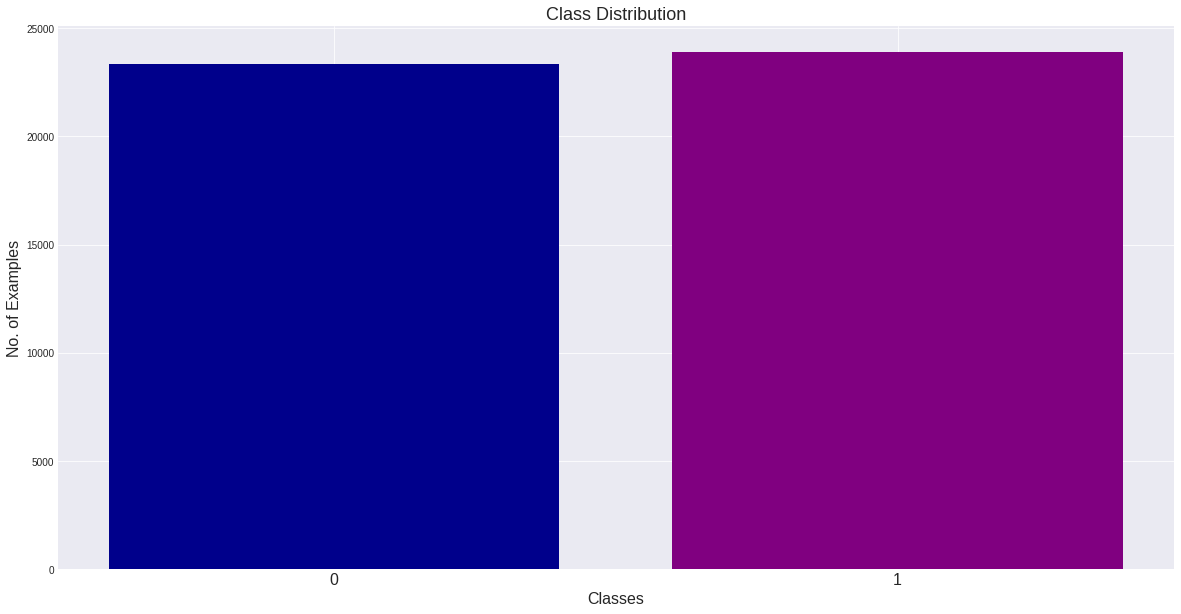

In [ ]:
# plot the new class distribution
plt.figure(figsize=(20, 10))
plt.bar(Y_res.unique(), Y_res.value_counts(), color = ['purple','darkblue'])
plt.xticks(Y_res.unique(), fontsize=16)
plt.xlabel('Classes', fontsize=16)
plt.ylabel('No. of Examples', fontsize=16)
plt.title('Class Distribution', fontdict={'fontsize': 18})
plt.show()

## **Model Building  🚀**

In [ ]:
# set a common random state throughout
RANDOM_STATE = 42

In [ ]:
# split into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X_res, Y_res, test_size = 0.2, shuffle = True, stratify = Y_res, random_state = RANDOM_STATE)

In [ ]:
# convert to arrays before feeding to model
X_train = np.array(X_train)
X_test  = np.array(X_test)

In [ ]:
# helper function for model instantiation
def initialize_model(model_name):
    if (model_name == 'decision_tree'):
        model = DecisionTreeClassifier(max_depth = 100,criterion='gini',random_state=RANDOM_STATE)
    elif (model_name == 'random_forest'):
        model = RandomForestClassifier(n_estimators=100,max_depth= 100, min_samples_split = 5, 
                                       criterion='gini',random_state=RANDOM_STATE)
    elif (model_name == 'xgboost'):
        model = xgb.XGBClassifier(max_depth = 10, booster = 'gbtree',importance_type = 'gini', 
                                  random_state = RANDOM_STATE)
    return model

# helper function for LIME visualization
def lime_metrics(model, n_features=15):
    
    explainer = LimeTabularExplainer(X_res.values,
                                 mode = 'classification',
                                 feature_names = X_res.columns.values, 
                                 categorical_features = [1,2,3,4,5,6,19,20,21,22,23,24,25,26,27,28,29,30],
                                 class_names=['Will Not Default', 'Will Default'], 
                                 discretize_continuous=True,
                                 verbose=False,
                                 random_state=RANDOM_STATE)
  
    choice = np.random.randint(0, X_test.shape[0])
    print("Model Predicted: {}".format(model.predict(X_test[choice].reshape(1, -1))))
    print("Ground Truth: {}".format(Y_test.iloc[choice]))
    exp = explainer.explain_instance(X_test[choice], model.predict_proba, num_features = n_features)
    plt = exp.as_pyplot_figure()
    plt.tight_layout()
    exp.show_in_notebook(show_all=True)

### **Decision Tree**

In [ ]:
decision_tree_clf = initialize_model('decision_tree')
scores = cross_val_score(decision_tree_clf, X_train, Y_train, cv=5)
print("KFold Validation Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

KFold Validation Accuracy: 0.80 (+/- 0.01)


In [ ]:
decision_tree_clf.fit(X_train, Y_train)
print("Test Accuracy: {}".format(decision_tree_clf.score(X_test, Y_test)))

Test Accuracy: 0.8101078452104039


Model Predicted: [1]
Ground Truth: 1


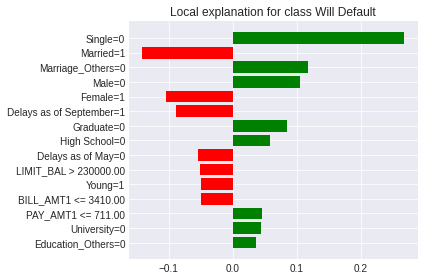

In [ ]:
lime_metrics(decision_tree_clf, n_features = 15)

#### **Observations**



---

*Note: The graphs change for every test example. So if the cells are rerun, some of the mentioned observations may not be seen. The test examples are chosen randomly.*

**Correlation Graph (Bottom Left)**

1. In the graph, we see that `Female=1`, `Delays as of May=0` and `Delays as of September=1` are all **negatively** correlated to the class `Will Default` which matches our EDA insights. 

2. In the same graph, we see that `University=0`, `Graduate=0` and `High School=0` are all also **positively** correlated to defaulting, again matching our EDA.

3. If the `BILL_AMT1` (Bill as of September) is **less** than `3410.00`, defaulting is **negatively** correlated. 

4. Also, if `PAY_AMT1` (Amount paid in September) is **less** than `711.00`, there is a **positive** correlation with defaulting which agrees with our EDA.

4. One contradiction to our EDA is that `Marriage=1` is **negatively** correlated to defaulting. 


** We can verify that all the other graphs are different representations of the Correlation Graph and hence give us the same observations ** 

---




### **Random Forest**

In [ ]:
random_forest_clf = initialize_model('random_forest')
scores = cross_val_score(random_forest_clf, X_train, Y_train, cv=5)
print("KFold Validation Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

KFold Validation Accuracy: 0.87 (+/- 0.00)


In [ ]:
random_forest_clf.fit(X_train, Y_train)
print("Test Accuracy: {}".format(random_forest_clf.score(X_test, Y_test)))

Test Accuracy: 0.8815817297525904


Model Predicted: [1]
Ground Truth: 1


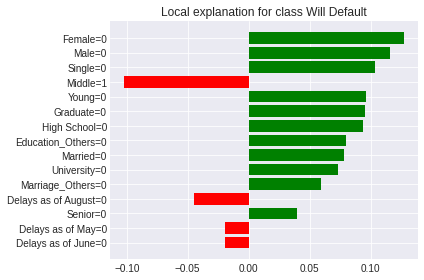

In [ ]:
lime_metrics(random_forest_clf, n_features = 15)

#### **Observations**



---

*Note: The graphs change for every test example. So if the cells are rerun, some of the mentioned observations may not be seen. The test examples are chosen randomly.*

**Correlation Graph (Bottom Left)**

1. According to the model, `Delays as of August=0`, `Delays as of May=0`, `Delays as of June=0` are all **negatively** correlated to defaulting, which matches our EDA.

2. A very strong **negative** correlation is found for `Middle=1` with respect to defaulting.

3. Like for Decision Tree, here too we see that `University=0`, `Graduate=0` and `High School=0` are all **positively** correlated to defaulting, again matching our EDA.


** We can verify that all the other graphs are different representations of the Correlation Graph and hence give us the same observations ** 

---




### **XGBOOST**

In [ ]:
xgboost_clf = initialize_model('xgboost')
scores = cross_val_score(xgboost_clf, X_train, Y_train, cv=5)
print("KFold Validation Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

KFold Validation Accuracy: 0.87 (+/- 0.01)


In [ ]:
xgboost_clf.fit(X_train, Y_train)
print("Test Accuracy: {}".format(xgboost_clf.score(X_test, Y_test)))

Test Accuracy: 0.8754493550433495


Model Predicted: [1]
Ground Truth: 1


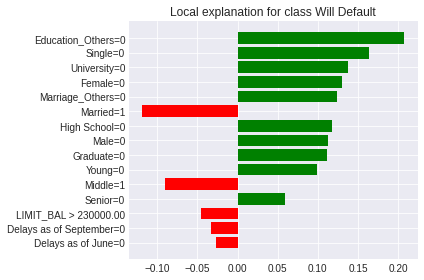

In [ ]:
lime_metrics(xgboost_clf, n_features = 15)

#### **Observations**



---

*Note: The graphs change for every test example. So if the cells are rerun, some of the mentioned observations may not be seen. The test examples are chosen randomly.*

**Correlation Graph (Bottom Left)**

1. According to the model, `Delays as of September=0` and `Delays as of June=0` are **negatively** correlated to defaulting, which matches our EDA.

2. A very strong **negative** correlation is found for `Marriage=1` with respect to defaulting which matches our EDA. The **opposite** is seen in the **Decision Tree** which may have contributed to Decision Tree having **~7% lower accuracy.** 

3. Like for Decision Tree, here too we see that `University=0`, `Graduate=0` and `High School=0` are all **positively** correlated to defaulting, again matching our EDA.


** We can verify that all the other graphs are different representations of the Correlation Graph and hence give us the same observations ** 

---




### **Partial Dependance Plots**

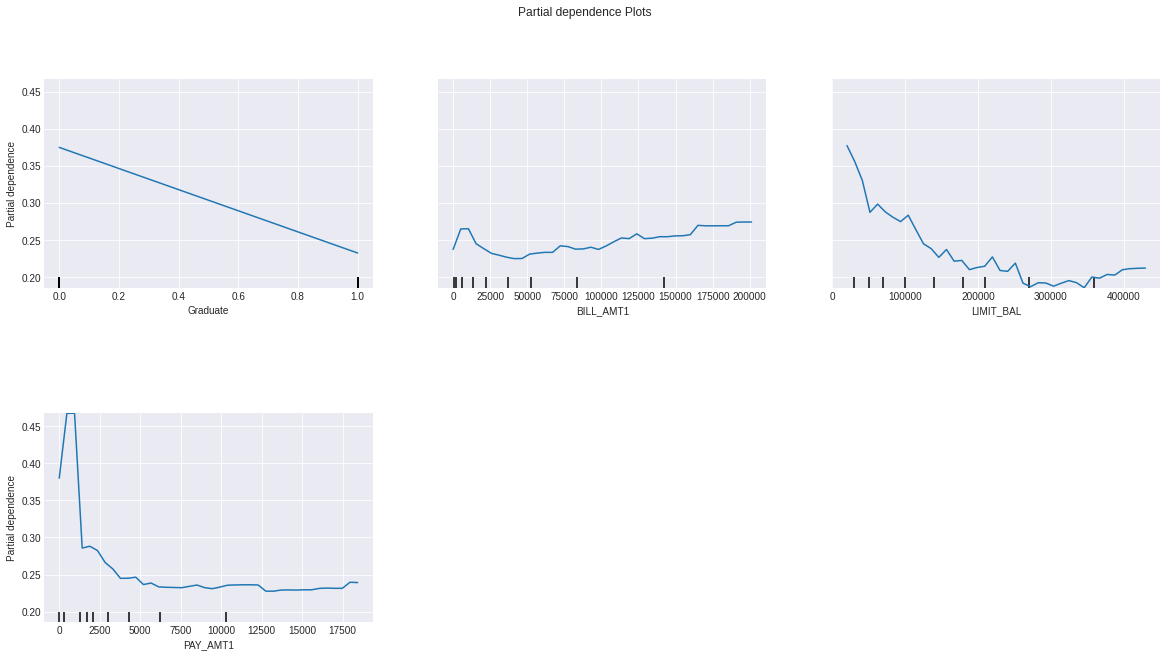

In [ ]:
features = ['Graduate', 'BILL_AMT1', 'LIMIT_BAL', 'PAY_AMT1']

plot_partial_dependence(models[0][1], X, features,
                        n_jobs=-1, grid_resolution=40)

fig = plt.gcf()
fig.set_size_inches(20,10)
fig.suptitle('Partial dependence Plots')
fig.subplots_adjust(hspace=0.6)

## **Summary 🔖**

In [ ]:
models = [('Decision Tree',decision_tree_clf), ('Random Forest',random_forest_clf), ('XGBoost',xgboost_clf)]
print("*** SUMMARY OF TEST ACCURACIES ***\n")
for name, clf in models:
    print('{} \t: {}'.format(name, clf.score(X_test, Y_test)))

*** SUMMARY OF TEST ACCURACIES ***

Decision Tree 	: 0.8101078452104039
Random Forest 	: 0.8815817297525904
XGBoost 	: 0.8754493550433495


In [ ]:
def plot_confusion(models):
    
    fig, axes = plt.subplots(1,3,figsize=(20,5))
    for i in range(len(models)):
        conf_mat = confusion_matrix(Y_test, models[i][1].predict(X_test))
        sns.heatmap(conf_mat/len(X_test), annot = True,ax=axes[i])
        axes[i].set_xlabel('Predicted Classes')
        axes[i].set_ylabel('Actual Classes')
        axes[i].set_title(models[i][0])
    plt.show()

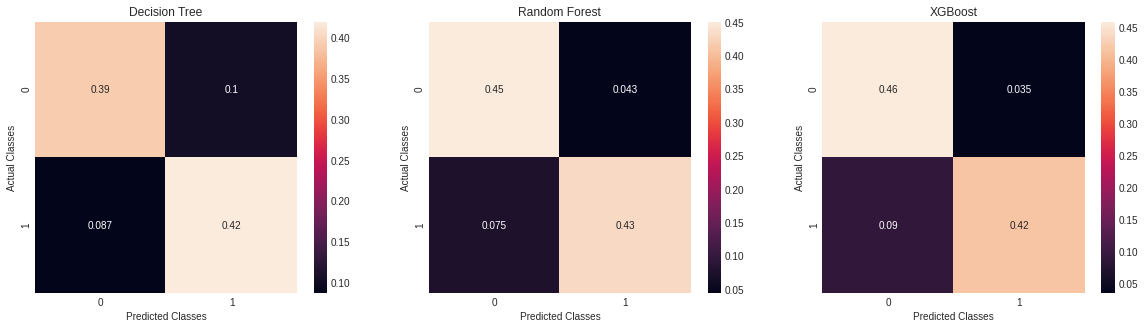

In [ ]:
plot_confusion(models)

## **Conclusions ⚖️**

---

1. Almost all the insights we derived from EDA, are confirmed by the models by visualizing with LIME over runs.

2. The PDP's also agree with our derived insights.

---


